# Project: Disease detection from Chest X-Ray

## 🧠 Project Goal:

Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

## 📦 Dataset:

Chest X-Ray Images (Pneumonia) – Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

    5,863 total images across training, test, and validation folders

    Two classes: NORMAL, PNEUMONIA

### Importing Important Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMG_SIZE = (150, 150) ## Resizing images
BATCH_SIZE = 32

### Data Exploration

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [4]:
dataset_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [5]:
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)

In [6]:
import os
from collections import Counter

def count_classes(folder):
    normal = len(os.listdir(f"{folder}/NORMAL"))
    pneumonia = len(os.listdir(f"{folder}/PNEUMONIA"))
    return {'NORMAL': normal, 'PNEUMONIA': pneumonia}

print("Train:", count_classes(f"{dataset_dir}/train"))
print("Test:", count_classes(f"{dataset_dir}/test"))

Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


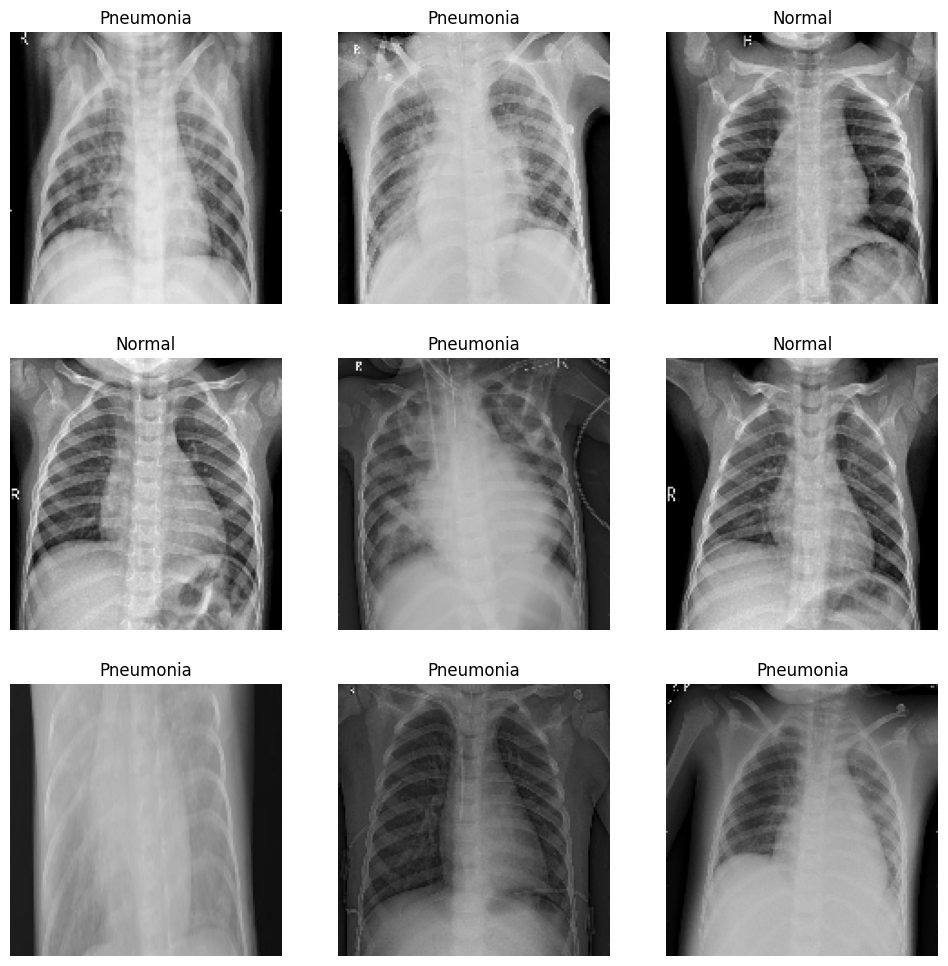

In [7]:
images, labels = next(iter(train_ds))
plt.figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # images[i] is already [0,1] floats, no conversion needed
    plt.imshow(images[i].numpy())
    label = "Normal" if labels[i] == 0 else "Pneumonia"
    plt.title(label)
    plt.axis("off")

plt.show()


We have 3876 chest xrays of patients diagnosed with pneumonia and 1342 chest xrays of healthy patients.
The number of pneumonia chest xrays is almost 3x that of normal chest xrays

### Create the convolutional base

In [8]:
from tensorflow.keras import mixed_precision

# Disable mixed precision
mixed_precision.set_global_policy('float32')


# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),               # flatten before dense
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,865 (9.39 MB)

 Trainable params: 2,460,865 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile and train the model

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # or more if you want
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.7616 - loss: 0.5252 - val_accuracy: 0.6250 - val_loss: 0.8743
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.8647 - loss: 0.3122 - val_accuracy: 0.8750 - val_loss: 0.6890
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.8958 - loss: 0.2872 - val_accuracy: 0.8125 - val_loss: 0.6702
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.9191 - loss: 0.2615 - val_accuracy: 0.8750 - val_loss: 0.6687
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.9289 - loss: 0.2381 - val_accuracy: 0.6875 - val_loss: 0.7687
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.9381 - loss: 0.2117 - val_accuracy: 0.6875 - val_loss: 0.8820
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.9417 - loss: 0.1993 - val_accuracy: 0.7500 - val_loss: 0.6022
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.9232 - loss: 0

### Evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
              precision    recall  f1-score   support

      NORMAL       0.36      0.18      0.24       234
   PNEUMONIA       0.62      0.81      0.70       390

    accuracy                           0.57       624
   macro avg       0.49      0.50      0.47       624
weighted avg       0.53      0.57      0.53       624



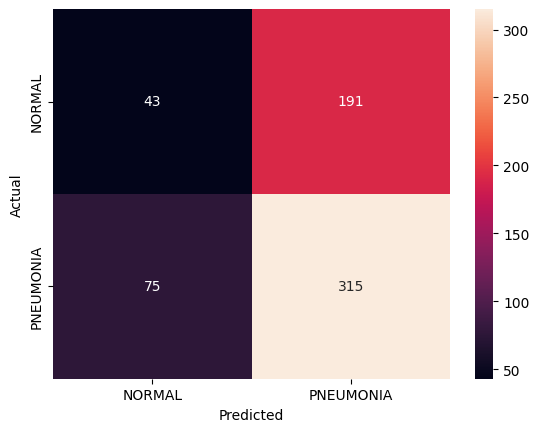

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get model predictions
preds = model.predict(test_ds)
y_pred = (preds > 0.5).astype(int).flatten()  # for binary classification

# Classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The model currently shows moderate effectiveness in detecting pneumonia, achieving a recall of 81% for positive cases but only 62% precision. Its performance in identifying healthy cases is weak, with a recall of 18%. With an overall accuracy of 57%, the model is not yet suitable for clinical deployment. Improving class balance, refining the network architecture, and adjusting decision thresholds could help enhance both sensitivity and specificity.

### Curves

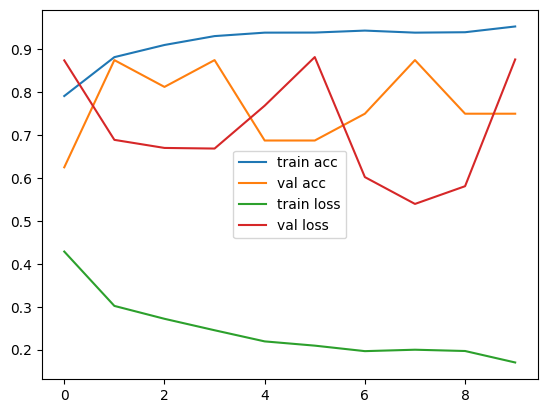

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()